## Comments on Filtering 

Consider a reference sequence, length $L$, and a pool of other sequences to compare with. In a genome, there are $N \approx 4\times 10^6$ other sequences to compare with the reference. 
\begin{align*}
    L \text{ choose } n &\text{ number of combinations}\\
    (1/4)^{L - n}(3/4)^n &\text{ probabilty a combination is observed}
\end{align*}
Hence we define the following $E(n)$, which is the number of sequences expected to have $n$ differences. 
$$
E(n) = N \bigg(\frac{(L \text{ choose }n)3^n}{4^L} \bigg)
$$
We want to filter so that $E(n)$ is less than a threshold, $\tau = 0.1$. 

In [44]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import entropy


In [30]:
# Load wildtype data

GENE = 'ykgE'

WT_GENES_FPATH = "../data/wtsequences.csv"

wildtype_genes_df = pd.read_csv(WT_GENES_FPATH)

WT_GENE_SEQUENCES = {
    g: wildtype_genes_df.loc[wildtype_genes_df['name'] == g,'geneseq'].values[0]
    for g in wildtype_genes_df['name'].unique()
}

GENE_WT_SEQ = WT_GENE_SEQUENCES[GENE]

nbases = len(GENE_WT_SEQ)
print(f"{GENE} wildtype sequence (length {nbases}):\n", GENE_WT_SEQ)
wildtype_genes_df.head()

ykgE wildtype sequence (length 160):
 TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG


,Unnamed: 0,name,start_site,rev,geneseq,ssdiff,offset
0,0,fdoH,4085867.0,rev,CATTATGGTATTCTGTTACAAACCCTTCCTGGATGGAGGGAAATTG...,0.0,0.0
1,3,sdaB,2928035.0,fwd,TACATATATTGCGCGCCCCGGAAGAAGTCAGATGTCGTTTAATGGG...,0.0,0.0
2,6,thiM,2185451.0,rev,TCTGGATGTCGTTCTGAAGGTGCTGGATTCATATATCAAATAATTT...,0.0,0.0
3,7,yedJ,2033449.0,rev,TTTTTCCTGTATTCACTGCCGTTGCGCAAAATTTATCTATTTGTTC...,0.0,0.0
4,9,ykgE,321511.0,fwd,TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,0.0,0.0


[3, 1, 2, 0, 3, 3, 3, 1, 1, 1, 1, 0, 3, 0, 0, 0, 0, 3, 2, 3, 2, 0, 2, 1, 2, 0, 3, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 2, 3, 3, 0, 3, 3, 2, 1, 0, 3, 3, 3, 2, 0, 1, 2, 3, 3, 3, 2, 2, 0, 3, 2, 0, 0, 0, 2, 0, 3, 3, 0, 3, 1, 0, 3, 3, 3, 2, 3, 1, 0, 3, 0, 1, 0, 0, 0, 3, 2, 0, 2, 2, 2, 2, 3, 2, 2, 3, 0, 3, 2, 3, 3, 2, 1, 3, 0, 2, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1, 1, 0, 3, 0, 3, 3, 3, 0, 3, 3, 2, 0, 3, 2, 0, 3, 3, 2, 0, 3, 1, 1, 1, 1, 1, 2, 2]
0      ['TCGAGTTCACCATCAAAAGAGAGGAATACAgcgaccgtatgcgc...
1      ['GCGATTGCCCCGGAAAATGTGGCTTATGTCggcgatgatctcat...
2      ['TCGGTTTCCCCCTCTTATTTGTACGATGTCggtccttatctgat...
3      ['TCGATTTCCCCATAAAATGTGAGCGATGCCgaaagaaataaaat...
4      ['GCGATTGCCCCGGAAAATGTGGCTTATGTCggcgatgatctcat...
                             ...                        
995    ['TCGATTTCCCCATAAAATGTGAGCGATGCCgaaagaaataaaat...
996    ['TCGAGTTCACCATCAAAAGAGAGGAATACAgcgaccgtatgcgc...
997    ['TCGATTTCCCCATAAAATGTGAGCGATGCCgaaagaaataaaat...
998   

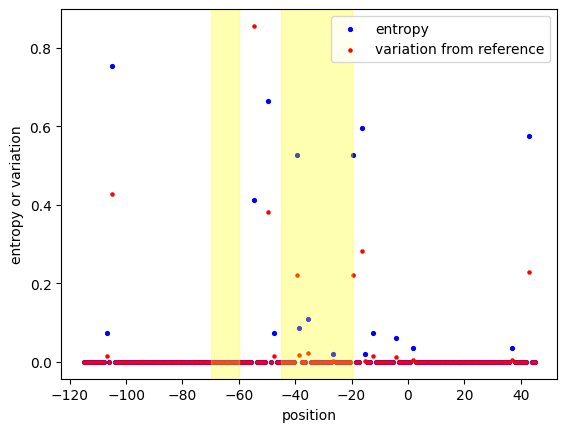

In [55]:
FPATH = '../out/ykgE_1000.tsv' 

wt = [NT_MAP[c.upper()] for c in GENE_WT_SEQ if c.upper() in ['A', 'C', 'T', 'G']]
print(wt)

NT_MAP = {c: i for i, c in enumerate(['A', 'C', 'G', 'T'])}

df = pd.read_csv(FPATH, sep = '\t')
print(df['contig_segments'])

tau = 0.1 #threshold
N = 4*10**6 #genome length
L = len(df['query_string'][0]) #query length
print(L)
def E(n):
    comb = math.comb(L, n)
    return N*(comb*3**n/4**L)


seqs = []
for i in range(len(df['contig_segments'])):
    if E(int(df['min_distance'][i])) < tau:
        sequence = df['contig_segments'][i]
        numeric_sequence = [NT_MAP[c.upper()] for c in sequence if c.upper() in ['A', 'C', 'T', 'G']]
        print(numeric_sequence)
        seqs.append(numeric_sequence)
        


variation = np.zeros(len(wt))
for i in range(len(variation)):
    for j in range(len(seqs)):
        if seqs[j][i] != wt[i]:
            variation[i] += 1/len(seqs)


print(len(seqs))

def calculate_entropy(seqs):
    seqs = np.array(seqs)
    num_seqs, seq_length = seqs.shape
    entropies = np.zeros(seq_length)
    for i in range(seq_length):
        values, counts = np.unique(seqs[:, i], return_counts=True)
        entropies[i] = entropy(counts)
    return entropies

entropies = calculate_entropy(seqs)

binding_sites = [(-70, -60), (-45, -20)]

        
x = np.linspace(-115, 45, len(wt))    
plt.scatter(x, entropies, s = 7.5, color = 'blue', label = 'entropy')

plt.scatter(x, variation, s = 5, color = 'red', label = 'variation from reference')

for start, end in binding_sites:
    plt.axvspan(start, end, color='yellow', alpha=0.3)


plt.xlabel('position')
plt.ylabel('entropy or variation')
plt.legend()


In [48]:
print(E(30))

714.328360680059
